# Sentiment Analysis with Word Normalization

Importing library

In [5]:
import pandas as pd
import nltk
import numpy as np
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
import re
import io
import time
from datetime import timedelta
import logging
logging.basicConfig(level=logging.INFO)
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
#import gensim
#from gensim.models.wrappers import FastText

[nltk_data] Downloading package punkt to C:\Users\Win
[nltk_data]     10\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Win
[nltk_data]     10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
INFO:matplotlib.font_manager:Generating new fontManager, this may take some time...


In [8]:
#from google.colab import drive
#drive.mount('/content/drive')

# Load Data

In [32]:
labeled = pd.read_csv('Tweets Labeled.csv', error_bad_lines=False, sep = '\t')
ciptakerja = pd.read_csv('ciptakerja.csv')
omnibus = pd.read_csv('omnibuslaw.csv')
omnibus = omnibus.rename(columns={'0': "id", '1': "date", '2': "Tweet",'3':'RT','4':'favorites','5':'mentions','6':'geo'})
omnibus.head()

,id,date,Tweet,RT,favorites,mentions,geo
0,1301815267954061312,2020-09-04 09:32:01+00:00,Dengan omnibuslaw pemberi kerja dilarang membayar gaji dibawah gaji minimum.. #DukungOmnibusLaw,0,0,NaN,NaN
1,1301815086378491906,2020-09-04 09:31:17+00:00,"Pdhl idi sampe salesnl farmasinya udh teriak LD dr awal.. tergantung penilaianmu masih benarkah, belum omnibuslaw dll..masih elu belain ? Kebangetan lu",0,0,NaN,NaN
2,1301814678675271681,2020-09-04 09:29:40+00:00,Dengan Omnibuslaw pekerja dan buruh yang lembur wajib dibayar.. #DukungOmnibusLaw,0,0,NaN,NaN
3,1301814467383050242,2020-09-04 09:28:50+00:00,Omnibuslaw memberikan keringanan Izin UMKM.. #DukungOmnibusLaw,0,0,NaN,NaN
4,1301814167431593984,2020-09-04 09:27:38+00:00,Dengan Omnibuslaw pengusaha wajib bayar lembur.. #DukungOmnibusLaw,0,0,NaN,NaN


In [33]:
omnibus.isnull().sum()

id              0
date            0
Tweet           0
RT              0
favorites       0
mentions     5994
geo          6764
dtype: int64

In [34]:
omnibus = omnibus.drop(columns=['mentions','geo'])
omnibus.isnull().sum()

id           0
date         0
Tweet        0
RT           0
favorites    0
dtype: int64

In [8]:
# data contain slang words
slang = pd.read_csv('colloquial-indonesian-lexicon.csv', error_bad_lines = False)
slang.head()

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,Selamat ulang tahun kakak tulus semoga panjang...,elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @t...,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @t...,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0


create dict for slang and formal words

In [9]:
slang_dict ={}
for i in range(len(slang)):
  slang_dict[slang.iloc[i]['slang']] =  slang.iloc[i]['formal']

In [419]:
slang_dict

{'woww': 'wow',
 'aminn': 'amin',
 'met': 'selamat',
 'netaas': 'menetas',
 'keberpa': 'keberapa',
 'eeeehhhh': 'eh',
 'kata2nyaaa': 'kata-katanya',
 'hallo': 'halo',
 'kaka': 'kakak',
 'ka': 'kak',
 'daah': 'dah',
 'aaaaahhhh': 'ah',
 'yaa': 'ya',
 'smga': 'semoga',
 'slalu': 'selalu',
 'amiin': 'amin',
 'kk': 'kakak',
 'trus': 'terus',
 'sii': 'sih',
 'nyenengin': 'menyenangkan',
 'bgt': 'banget',
 'gemess': 'gemas',
 'akuuu': 'aku',
 'jgn': 'jangan',
 'udah': 'sudah',
 'gitu': 'begitu',
 'aja': 'saja',
 'gemesiin': 'menggemaskan',
 'menyenangkn': 'menyenangkan',
 'rb': 'ribu',
 'akau': 'aku',
 'saranin': 'menyarankan',
 'nemuin': 'menemukan',
 'yah': 'ya',
 'mnis2nya': 'manis-manisnya',
 'gtu': 'begitu',
 'tu': 'itu',
 'idolaa': 'idola',
 'bangett': 'banget',
 'kaakk': 'kak',
 'baaiikkk': 'baik',
 'telaatt': 'telat',
 'kaak': 'kak',
 'yg': 'yang',
 'lg': 'lagi',
 'skarang': 'sekarang',
 'sempet': 'sempat',
 'karna': 'karena',
 'ngga': 'enggak',
 'mantep': 'mantap',
 'loohhh': 'loh',

In [227]:
pd.options.display.max_colwidth = 1000
pd.options.display.max_rows = 1000

# Text Normalization

In [11]:
punc = [i for i in string.punctuation]

In [159]:
def preprocess_tweet(tweet):
    tweet = tweet.lower()#make all tweet lower case
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet) # remove URLs
    tweet = re.sub('@[^\s]+', ' ', tweet) # remove usernames
    tweet = re.sub(r'#([^\s]+)', r' ', tweet) # remove  #hashtag
    tweet = re.sub(r'\b[Rr][Tt]\b',r' ',tweet)#remove RT
    #Remove emoji
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    tweet=regrex_pattern.sub(r'',tweet)
    tweet=re.sub('\d',' ',tweet)#remove digit
    #replace punctuation with whitespace 
    for p in punc:
        tweet=tweet.replace(p,' ')
    
    tweet=re.compile(r"\s+").sub(" ", tweet).strip()#remove additional whitespace
    #tweet = tweet.translate(str.maketrans(' ',' ',string.punctuation))#remove punctuation
    tokens = nltk.tokenize.word_tokenize(tweet)
    
    #Remove punctuation
    listStopword =  set(stopwords.words('indonesian'))
    removed = []
    for t in tokens:
        if t not in listStopword:
            removed.append(t)
    """        
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    #tokenize
    tokenize=[]
    for r in removed:
        katadasar = stemmer.stem(r)
        tokenize.append(katadasar)
    """
    return " ".join( [r for r in removed if len(r)>1] )

## Replace the contractions for their actual words

In [161]:
def _normalize_contractions_text(text):
  contractions = slang_dict
  new_token_list = []
  token_list = text.split()
  for word_pos in range(len(token_list)):
    word = token_list[word_pos]
    first_upper = False
    if word[0].isupper():
      first_upper = True
    if word.lower() in contractions:
      replacement = contractions[word.lower()]
      if first_upper:
        replacement = replacement[0].upper()+replacement[1:]
      replacement_tokens = replacement.split()
      if len(replacement_tokens)>1:
        new_token_list.append(replacement_tokens[0])
        #print(new_token_list)
        new_token_list.append(replacement_tokens[1])
        #print(new_token_list)
      else:
        new_token_list.append(replacement_tokens[0])
        #print(new_token_list)
    else:
      new_token_list.append(word)
      #print(new_token_list)
  sentence = " ".join(new_token_list).strip(" ")
  return(sentence)
  

## Lemmetization

In [162]:
# initiate lemmetization
nlp=spacy.blank('id') 
def lemmatize(sentence):
  new_sent = []
  doc = nlp(sentence)
  for token in doc:
      ori = token.text
      lemma = token.lemma_  # token.lemma is integer index
      new_sent.append(lemma)
  return " ".join(new_sent)

## Spell checking

#### Import library for spell checking

#### Downloading data for spell checking

#### Instantiate spell checker

#### Function for spell checking

## Clean data

In [163]:
#Clean dataset untuk train dan test model
labeled2 = labeled.copy()
labeled2['kalimat'] = labeled2['Tweet'].apply(preprocess_tweet)
labeled2['kalimat'] = labeled2['Tweet'].apply(_normalize_contractions_text)
labeled2['kalimat'] = labeled2['Tweet'].apply(lemmatize)

#Clean data omnibuslaw untuk test
omnibus2 = omnibus.copy()
omnibus2['kalimat'] = omnibus2['Tweet'].apply(preprocess_tweet)
omnibus2['kalimat'] = omnibus2['Tweet'].apply(_normalize_contractions_text)
omnibus2['kalimat'] = omnibus2['Tweet'].apply(lemmatize)

# Split Data

In [164]:
labeled2['sentimen'].value_counts()
netral = labeled2[labeled2['sentimen']==0].copy()
positif = labeled2[labeled2['sentimen']==1].copy()
negatif = labeled2[labeled2['sentimen']==-1].copy()

train_netral = netral[0:4261]
train_positif = positif[0:2309]
train_negatif = negatif[0:2073]

test_netral = netral[4261:]
test_positif = positif[2309:]
test_negatif = negatif[2073:]

train = pd.concat([train_netral,train_positif,train_negatif])
test=pd.concat([test_netral,test_positif,test_negatif])
train.reindex(np.random.permutation(len(train)))
test.reindex(np.random.permutation(len(test)))
print(train.shape)
print(test.shape)

(8643, 3)
(2163, 3)


# Vectorized Words

## 1.Bag of Words

In [165]:
def bow_clean(tweets):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(tweets['kalimat'])
    bow = pd.DataFrame(X.toarray(),index=np.arange(len(tweets)),columns=vectorizer.get_feature_names())
    return bow

In [166]:
def bow(tweets):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(tweets['Tweet'])
    bow = pd.DataFrame(X.toarray(),index=np.arange(len(tweets)),columns=vectorizer.get_feature_names())
    return bow

### A.Tweet Sudah Dibersihkan

In [203]:
train_cv_clean = train.copy()
test_cv_clean=test.copy()
#buat frekuensi table
bow_train_cv_clean = bow_clean(train_cv_clean)
counts = bow_train_cv_clean.sum(axis=0)
bow_train_cv_clean = bow_train_cv_clean.loc[:,(counts>=5)]

bow_test_cv_clean=bow_clean(test_cv_clean)
counts = bow_test_cv_clean.sum(axis=0)
bow_test_cv_clean = bow_test_cv_clean.loc[:,(counts>=5)]

bow_omnibus = bow_clean(omnibus2)
counts = bow_omnibus.sum(axis=0)
bow_omnibus = bow_omnibus.loc[:,(counts>=5)]

#samain kolom tiap df
bow_train_cols_cv=bow_train_cv_clean.columns.tolist()
bow_test_cols_cv=bow_train_cv_clean.columns.tolist()
bow_omnibus_cols = bow_omnibus.columns.tolist()
all_cols=bow_train_cols_cv

for col in bow_test_cols_cv:
    if col not in all_cols:
        all_cols.append(col)
        
for col in bow_omnibus_cols:
    if col not in all_cols:
        all_cols.append(col)
        
bow_train_cv_clean = bow_train_cv_clean.reindex(columns=all_cols,fill_value=0)
bow_train_cv_clean = bow_train_cv_clean.reset_index(drop=True)

bow_test_cv_clean = bow_test_cv_clean.reindex(columns=all_cols,fill_value=0)
bow_test_cv_clean = bow_test_cv_clean.reset_index(drop=True)

bow_omnibus = bow_omnibus.reindex(columns=all_cols,fill_value=0)
bow_omnibus = bow_omnibus.reset_index(drop=True)

In [168]:
bow_test_cv_clean.shape

(2163, 4642)

In [169]:
bow_train_cv_clean.shape

(8643, 4642)

In [170]:
bow_omnibus.shape

(6764, 4642)

### B.Tweet belum dibersihkan

In [16]:
train_cv = train.copy()
test_cv = test.copy()

bow_train_cv = bow(train_cv)
bow_train_columns=train_cv.columns.tolist()

bow_test_cv = bow(test_cv)
bow_test_columns=test_cv.columns.tolist()


all_columns=bow_train_columns
for col in bow_test_columns:
    if col not in all_columns:
        all_columns.append(col)

bow_train_cv = train_cv.reindex(columns=all_columns,fill_value=0)
bow_test_cv = test_cv.reindex(columns=all_columns,fill_value=0)


## 2.TF-IDF

In [171]:
def tf_idf(tweets):
    vectorizer = TfidfVectorizer( stop_words=stopwords.words('indonesian'))
    processed_features = vectorizer.fit_transform(tweets).toarray()
    tf = pd.DataFrame(processed_features,index=np.arange(len(tweets)),columns=vectorizer.get_feature_names())
    return tf

### A.TFIDF dengan tweet belum dibersihkan

In [18]:
tf_train = tf_idf(train["Tweet"])
train_columns=tf_train.columns.tolist()

tf_test = tf_idf(test["Tweet"])
test_columns=tf_test.columns.tolist()


all_columns=train_columns
for col in test_columns:
    if col not in all_columns:
        all_columns.append(col)

tf_train = tf_train.reindex(columns=all_columns,fill_value=0)
tf_test = tf_test.reindex(columns=all_columns,fill_value=0)




c:\users\asus rog\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### TFIDF dengan tweet sudah dibersihkan

In [204]:
clean_tf_train = tf_idf(train["kalimat"])
counts = clean_tf_train.sum(axis=0)
clean_tf_train = clean_tf_train.loc[:,(counts>=5)]
clean_train_columns=clean_tf_train.columns.tolist()

clean_tf_test = tf_idf(test["kalimat"])
counts = clean_tf_test.sum(axis=0)
clean_tf_test = clean_tf_test.loc[:,(counts>=5)]
clean_test_columns=clean_tf_test.columns.tolist()

tf_omnibus = tf_idf(omnibus2["kalimat"])
counts = tf_omnibus.sum(axis=0)
tf_omnibus = tf_omnibus.loc[:,(counts>=5)]
tf_omnibus_cols = tf_omnibus.columns.tolist()

all_columns=clean_train_columns
for col in clean_test_columns:
    if col not in all_columns:
        all_columns.append(col)
        
for col in tf_omnibus_cols:
    if col not in all_columns:
        all_columns.append(col)    

clean_tf_train = clean_tf_train.reindex(columns=all_columns,fill_value=0)
clean_tf_train = clean_tf_train.reset_index(drop=True)

clean_tf_test = clean_tf_test.reindex(columns=all_columns,fill_value=0)
clean_tf_test = clean_tf_test.reset_index(drop=True)

tf_omnibus= tf_omnibus.reindex(columns=all_columns,fill_value=0)
tf_omnibus = tf_omnibus.reset_index(drop=True)

c:\users\win 10\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
c:\users\win 10\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
c:\users\win 10\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your prep

# Modelling

## 1.Naive Bayes

### A.Bag of Words
Tweet sudah ditokenisasi, text normalization (-spell checker)

In [205]:
mnb = MultinomialNB()
mnb.fit(bow_train_cv_clean,train_cv_clean['sentimen'])

MultinomialNB()

In [206]:
predicted = mnb.predict(bow_test_cv_clean)
unique_elements, counts_elements = np.unique(predicted, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[  -1    0    1]
 [ 223 1158  782]]


In [207]:
matrix = classification_report(test_cv_clean['sentimen'],predicted)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

          -1       0.65      0.18      0.28       814
           0       0.63      0.68      0.65      1066
           1       0.23      0.65      0.34       283

    accuracy                           0.49      2163
   macro avg       0.50      0.50      0.42      2163
weighted avg       0.58      0.49      0.47      2163



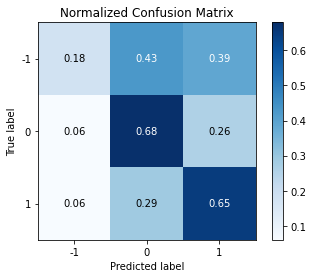

In [208]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(test_cv_clean['sentimen'], predicted, normalize=True)
plt.show()

#### ROC BOW MNB

In [209]:
y_score = label_binarize(predicted,classes=[-1,0,1])
y_test = label_binarize(test['sentimen'],classes=[-1,0,1])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(-1,2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

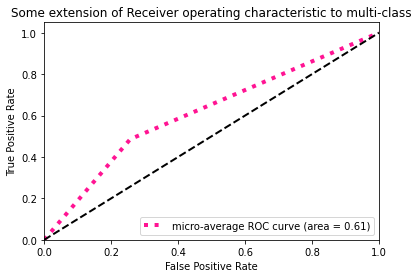

In [210]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

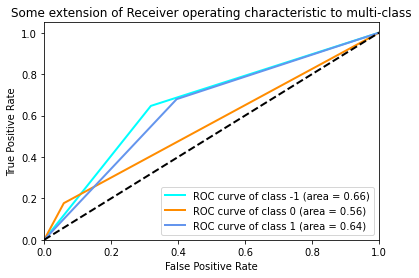

In [211]:
lw=2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(-1,2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [212]:
y_prob = mnb.predict_proba(bow_test_cv_clean)
y_test=test['sentimen']

In [213]:
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",average="weighted")

TypeError: 'DataFrame' object is not callable

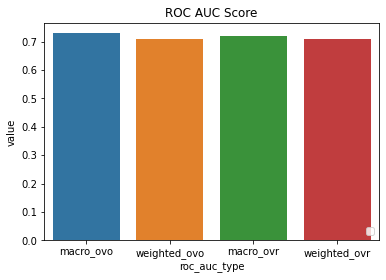

In [214]:
d= {'type':['macro_ovo','weighted_ovo','macro_ovr','weighted_ovr'],
    'value':[macro_roc_auc_ovo,weighted_roc_auc_ovr,macro_roc_auc_ovr,weighted_roc_auc_ovr]}
roc_auc_score = pd.DataFrame(data=d)

sns.barplot(x='type',y='value',data=roc_auc_score)

plt.xlabel('roc_auc_type')
plt.ylabel('value')
plt.title('ROC AUC Score')
plt.legend(loc="lower right")
plt.show()

#### EDA BOW MNB

In [215]:
#Predict sentiment dari dataset omnibuslaw
prediksi = mnb.predict(bow_omnibus)
omnibus2['sentimen'] = prediksi
omnibus2.head()

,id,date,Tweet,RT,favorites,kalimat,sentimen
0,1301815267954061312,2020-09-04 09:32:01+00:00,Dengan omnibuslaw pemberi kerja dilarang membayar gaji dibawah gaji minimum.. #DukungOmnibusLaw,0,0,Dengan omnibuslaw pemberi kerja dilarang membayar gaji dibawah gaji minimum .. #DukungOmnibusLaw,-1
1,1301815086378491906,2020-09-04 09:31:17+00:00,"Pdhl idi sampe salesnl farmasinya udh teriak LD dr awal.. tergantung penilaianmu masih benarkah, belum omnibuslaw dll..masih elu belain ? Kebangetan lu",0,0,"Pdhl idi sampe salesnl farmasinya udh teriak LD dr awal .. tergantung penilaianmu masih benarkah , belum omnibuslaw dll .. masih elu belain ? Kebangetan lu",-1
2,1301814678675271681,2020-09-04 09:29:40+00:00,Dengan Omnibuslaw pekerja dan buruh yang lembur wajib dibayar.. #DukungOmnibusLaw,0,0,Dengan Omnibuslaw pekerja dan buruh yang lembur wajib dibayar .. #DukungOmnibusLaw,1
3,1301814467383050242,2020-09-04 09:28:50+00:00,Omnibuslaw memberikan keringanan Izin UMKM.. #DukungOmnibusLaw,0,0,Omnibuslaw memberikan keringanan Izin UMKM .. #DukungOmnibusLaw,1
4,1301814167431593984,2020-09-04 09:27:38+00:00,Dengan Omnibuslaw pengusaha wajib bayar lembur.. #DukungOmnibusLaw,0,0,Dengan Omnibuslaw pengusaha wajib bayar lembur .. #DukungOmnibusLaw,1


<AxesSubplot:xlabel='sentimen', ylabel='count'>

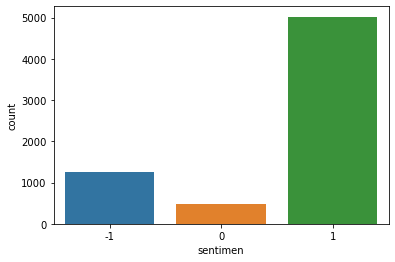

In [216]:
sns.countplot(x='sentimen',data=omnibus2)

In [217]:
group_sent = omnibus2.groupby(['sentimen']).sum()
group_sent['sentimen'] = group_sent.index
group_sent

,id,RT,favorites,sentimen
sentimen,,,,
-1,1.624676e+21,8221.0,18127.0,-1
0,6.227962e+20,1158.0,2993.0,0
1,6.475566e+21,24821.0,55443.0,1


<AxesSubplot:xlabel='sentimen', ylabel='favorites'>

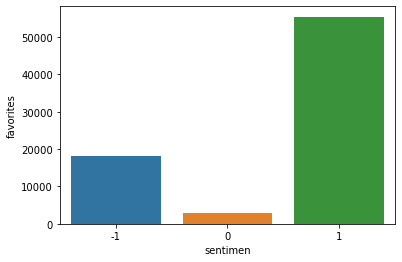

In [218]:
sns.barplot(x='sentimen',y='favorites',data=group_sent)

<AxesSubplot:xlabel='sentimen', ylabel='RT'>

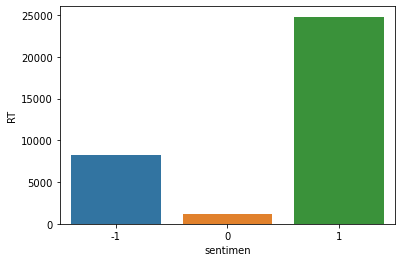

In [236]:
sns.barplot(x='sentimen',y='RT',data=group_sent)

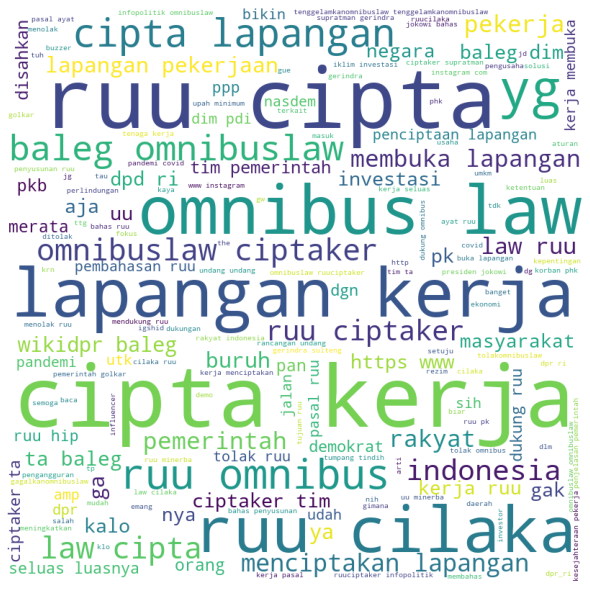

In [219]:
from wordcloud import WordCloud, STOPWORDS 
from nltk.corpus import stopwords

liststopwords =  set(stopwords.words('indonesian'))
tweets=''
for val in omnibus2['kalimat']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    tweets += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = liststopwords, 
                min_font_size = 10).generate(tweets)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

<AxesSubplot:xlabel='value', ylabel='key'>

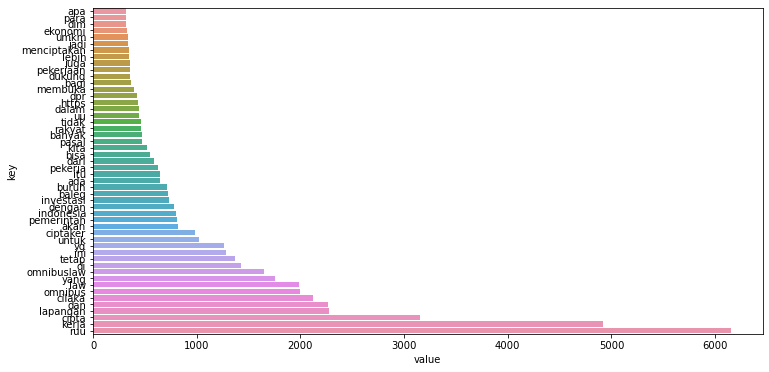

In [235]:
plt.figure(figsize=(12,6))
jumlah = bow_omnibus.sum(axis=0)
jumlah_dict={}
for i in jumlah.index:
    jumlah_dict[i] = jumlah[i]
sorted_jumlah_dict = sorted(jumlah_dict.items(), key=lambda item: item[1])
top_50 = sorted_jumlah_dict[-50:]
key = [i[0] for i in top_50]
value = [i[1] for i in top_50]
kamus = {'key':key,'value':value}
words = pd.DataFrame(data=kamus)
sns.barplot(y='key',x='value',data=words)

In [238]:
omnibus2.head()

,id,date,Tweet,RT,favorites,kalimat,sentimen
0,1301815267954061312,2020-09-04 09:32:01+00:00,Dengan omnibuslaw pemberi kerja dilarang membayar gaji dibawah gaji minimum.. #DukungOmnibusLaw,0,0,Dengan omnibuslaw pemberi kerja dilarang membayar gaji dibawah gaji minimum .. #DukungOmnibusLaw,-1
1,1301815086378491906,2020-09-04 09:31:17+00:00,"Pdhl idi sampe salesnl farmasinya udh teriak LD dr awal.. tergantung penilaianmu masih benarkah, belum omnibuslaw dll..masih elu belain ? Kebangetan lu",0,0,"Pdhl idi sampe salesnl farmasinya udh teriak LD dr awal .. tergantung penilaianmu masih benarkah , belum omnibuslaw dll .. masih elu belain ? Kebangetan lu",-1
2,1301814678675271681,2020-09-04 09:29:40+00:00,Dengan Omnibuslaw pekerja dan buruh yang lembur wajib dibayar.. #DukungOmnibusLaw,0,0,Dengan Omnibuslaw pekerja dan buruh yang lembur wajib dibayar .. #DukungOmnibusLaw,1
3,1301814467383050242,2020-09-04 09:28:50+00:00,Omnibuslaw memberikan keringanan Izin UMKM.. #DukungOmnibusLaw,0,0,Omnibuslaw memberikan keringanan Izin UMKM .. #DukungOmnibusLaw,1
4,1301814167431593984,2020-09-04 09:27:38+00:00,Dengan Omnibuslaw pengusaha wajib bayar lembur.. #DukungOmnibusLaw,0,0,Dengan Omnibuslaw pengusaha wajib bayar lembur .. #DukungOmnibusLaw,1


In [273]:
import datetime
omnibus2['dates'] = pd.to_datetime(omnibus2['date'], format="%Y-%m-%dT%H:%M:%S")
from datetime import datetime, timezone
import pytz

def utc_to_local(utc_dt):
    WIB = pytz.timezone("Asia/Jakarta")
    return utc_dt.astimezone(WIB)
omnibus2['dates'] = omnibus2['dates'].apply(lambda x: utc_to_local(x))
omnibus2['hour'] = omnibus2['dates'].apply(lambda x: pd.to_datetime(x).hour)
omnibus2['day_of_week'] = omnibus2['dates'].apply(lambda x: pd.to_datetime(x).dayofweek)
omnibus2['day'] = omnibus2['dates'].apply(lambda x: pd.to_datetime(x).day)
omnibus2['month'] = omnibus2['dates'].apply(lambda x: pd.to_datetime(x).month)
omnibus2.head()

,id,date,Tweet,RT,favorites,kalimat,sentimen,dates,hour,day_of_week,day,month
0,1301815267954061312,2020-09-04 09:32:01+00:00,Dengan omnibuslaw pemberi kerja dilarang membayar gaji dibawah gaji minimum.. #DukungOmnibusLaw,0,0,Dengan omnibuslaw pemberi kerja dilarang membayar gaji dibawah gaji minimum .. #DukungOmnibusLaw,-1,2020-09-04 16:32:01+07:00,16,4,4,9
1,1301815086378491906,2020-09-04 09:31:17+00:00,"Pdhl idi sampe salesnl farmasinya udh teriak LD dr awal.. tergantung penilaianmu masih benarkah, belum omnibuslaw dll..masih elu belain ? Kebangetan lu",0,0,"Pdhl idi sampe salesnl farmasinya udh teriak LD dr awal .. tergantung penilaianmu masih benarkah , belum omnibuslaw dll .. masih elu belain ? Kebangetan lu",-1,2020-09-04 16:31:17+07:00,16,4,4,9
2,1301814678675271681,2020-09-04 09:29:40+00:00,Dengan Omnibuslaw pekerja dan buruh yang lembur wajib dibayar.. #DukungOmnibusLaw,0,0,Dengan Omnibuslaw pekerja dan buruh yang lembur wajib dibayar .. #DukungOmnibusLaw,1,2020-09-04 16:29:40+07:00,16,4,4,9
3,1301814467383050242,2020-09-04 09:28:50+00:00,Omnibuslaw memberikan keringanan Izin UMKM.. #DukungOmnibusLaw,0,0,Omnibuslaw memberikan keringanan Izin UMKM .. #DukungOmnibusLaw,1,2020-09-04 16:28:50+07:00,16,4,4,9
4,1301814167431593984,2020-09-04 09:27:38+00:00,Dengan Omnibuslaw pengusaha wajib bayar lembur.. #DukungOmnibusLaw,0,0,Dengan Omnibuslaw pengusaha wajib bayar lembur .. #DukungOmnibusLaw,1,2020-09-04 16:27:38+07:00,16,4,4,9


(array([18474.70833333, 18478.70833333, 18482.70833333, 18486.70833333,
        18490.70833333, 18494.70833333, 18498.70833333, 18502.70833333,
        18505.70833333, 18509.70833333]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

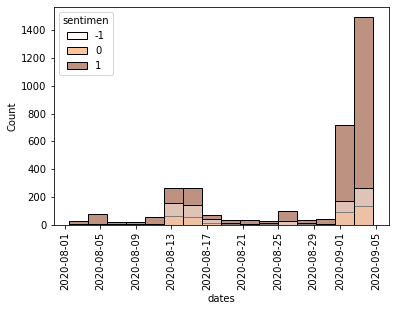

In [307]:
sns.set_palette("Reds")
terkini = omnibus2[(omnibus2['month']==8)|(omnibus2['month']==9)]
sns.histplot(terkini,x='dates',hue='sentimen',palette='Oranges')
plt.xticks(rotation=90)

(array([18373.70833333, 18382.70833333, 18403.70833333, 18413.70833333,
        18434.70833333, 18443.70833333, 18464.70833333, 18474.70833333,
        18495.70833333, 18505.70833333]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

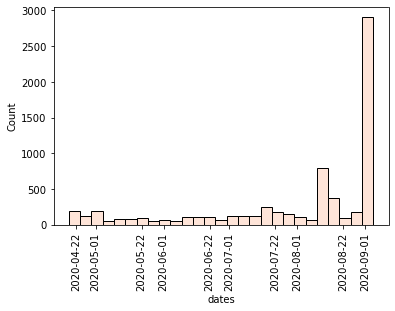

In [308]:
sns.histplot(omnibus2,x='dates')
plt.xticks(rotation=90)

<AxesSubplot:xlabel='hour', ylabel='count'>

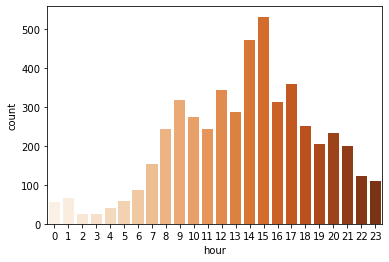

In [312]:
sns.countplot(x='hour',data=omnibus2[omnibus2['sentimen']==1],palette='Oranges')

<AxesSubplot:xlabel='hour', ylabel='count'>

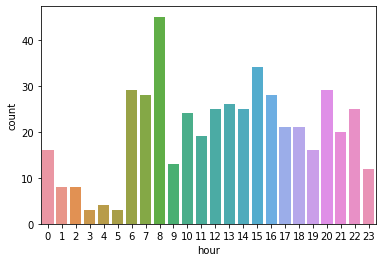

In [313]:
sns.countplot(x='hour',data=omnibus2[omnibus2['sentimen']==0])

<AxesSubplot:xlabel='hour', ylabel='count'>

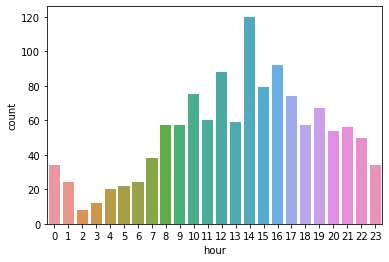

In [281]:
sns.countplot(x='hour',data=omnibus2[omnibus2['sentimen']==-1])

### B.TF-IDF


#### Tweet belum dibersihkan

In [31]:
from sklearn.naive_bayes import MultinomialNB
#preprocess data
mnb = MultinomialNB()
mnb.fit(tf_train,train['sentimen'])

MultinomialNB()

In [32]:
predicted = mnb.predict(tf_test)
unique_elements, counts_elements = np.unique(predicted, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[  -1    0    1]
 [ 134 1853  176]]


In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
matrix = classification_report(test['sentimen'],predicted)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

          -1       0.84      0.14      0.24       814
           0       0.55      0.96      0.70      1066
           1       0.49      0.31      0.38       283

    accuracy                           0.56      2163
   macro avg       0.63      0.47      0.44      2163
weighted avg       0.65      0.56      0.48      2163



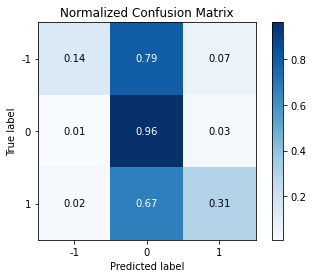

In [34]:
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(test['sentimen'], predicted, normalize=True)
plt.show()

#### Tweet sudah dibersihkan

In [314]:
#preprocess data
mnb = MultinomialNB()
mnb.fit(clean_tf_train, train['sentimen'])

MultinomialNB()

In [315]:
predicted = mnb.predict(clean_tf_test)
unique_elements, counts_elements = np.unique(predicted, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[  -1    0    1]
 [  29 2099   35]]


In [316]:
matrix = classification_report(test['sentimen'],predicted)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

          -1       0.72      0.03      0.05       814
           0       0.50      0.99      0.66      1066
           1       0.23      0.03      0.05       283

    accuracy                           0.50      2163
   macro avg       0.48      0.35      0.25      2163
weighted avg       0.55      0.50      0.35      2163



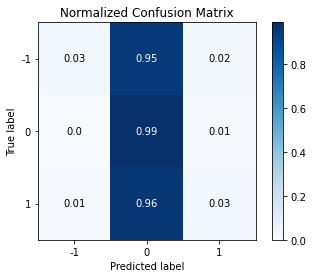

In [317]:
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(test['sentimen'], predicted, normalize=True)
plt.show()

### ROC

In [318]:
y_score = label_binarize(predicted,classes=[-1,0,1])
y_test = label_binarize(test['sentimen'],classes=[-1,0,1])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(-1,2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

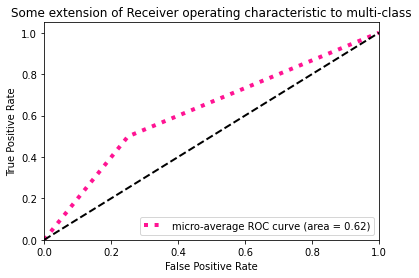

In [320]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

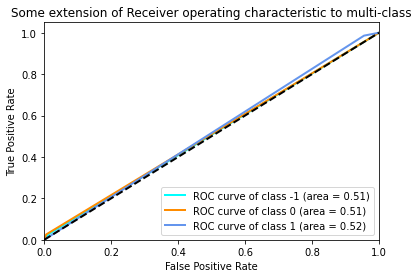

In [321]:
lw=2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(-1,2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [322]:
y_prob = mnb.predict_proba(clean_tf_test)
y_test=test['sentimen']

In [323]:
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",average="weighted")

TypeError: 'DataFrame' object is not callable

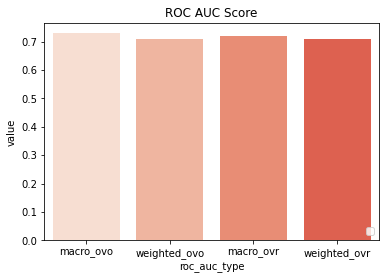

In [324]:
d= {'type':['macro_ovo','weighted_ovo','macro_ovr','weighted_ovr'],
    'value':[macro_roc_auc_ovo,weighted_roc_auc_ovr,macro_roc_auc_ovr,weighted_roc_auc_ovr]}
roc_auc_score = pd.DataFrame(data=d)

sns.barplot(x='type',y='value',data=roc_auc_score)

plt.xlabel('roc_auc_type')
plt.ylabel('value')
plt.title('ROC AUC Score')
plt.legend(loc="lower right")
plt.show()

#### EDA TFIDF MNB

In [325]:
#Predict sentiment dari dataset omnibuslaw
prediksi = mnb.predict(tf_omnibus)
omnibus2['sentimen'] = prediksi
omnibus2.head()

,id,date,Tweet,RT,favorites,kalimat,sentimen,dates,hour,day_of_week,day,month
0,1301815267954061312,2020-09-04 09:32:01+00:00,Dengan omnibuslaw pemberi kerja dilarang membayar gaji dibawah gaji minimum.. #DukungOmnibusLaw,0,0,Dengan omnibuslaw pemberi kerja dilarang membayar gaji dibawah gaji minimum .. #DukungOmnibusLaw,1,2020-09-04 16:32:01+07:00,16,4,4,9
1,1301815086378491906,2020-09-04 09:31:17+00:00,"Pdhl idi sampe salesnl farmasinya udh teriak LD dr awal.. tergantung penilaianmu masih benarkah, belum omnibuslaw dll..masih elu belain ? Kebangetan lu",0,0,"Pdhl idi sampe salesnl farmasinya udh teriak LD dr awal .. tergantung penilaianmu masih benarkah , belum omnibuslaw dll .. masih elu belain ? Kebangetan lu",0,2020-09-04 16:31:17+07:00,16,4,4,9
2,1301814678675271681,2020-09-04 09:29:40+00:00,Dengan Omnibuslaw pekerja dan buruh yang lembur wajib dibayar.. #DukungOmnibusLaw,0,0,Dengan Omnibuslaw pekerja dan buruh yang lembur wajib dibayar .. #DukungOmnibusLaw,1,2020-09-04 16:29:40+07:00,16,4,4,9
3,1301814467383050242,2020-09-04 09:28:50+00:00,Omnibuslaw memberikan keringanan Izin UMKM.. #DukungOmnibusLaw,0,0,Omnibuslaw memberikan keringanan Izin UMKM .. #DukungOmnibusLaw,0,2020-09-04 16:28:50+07:00,16,4,4,9
4,1301814167431593984,2020-09-04 09:27:38+00:00,Dengan Omnibuslaw pengusaha wajib bayar lembur.. #DukungOmnibusLaw,0,0,Dengan Omnibuslaw pengusaha wajib bayar lembur .. #DukungOmnibusLaw,0,2020-09-04 16:27:38+07:00,16,4,4,9


<AxesSubplot:xlabel='sentimen', ylabel='count'>

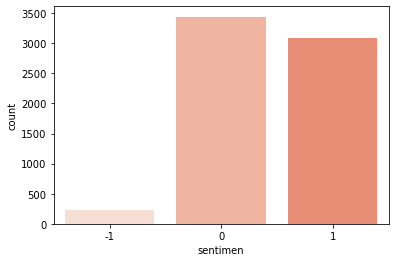

In [326]:
sns.countplot(x='sentimen',data=omnibus2)

In [327]:
group_sent = omnibus2.groupby(['sentimen']).sum()
group_sent['sentimen'] = group_sent.index
group_sent

,id,RT,favorites,hour,day_of_week,day,month,sentimen
sentimen,,,,,,,,
-1,2.968829e+20,2480.0,7845.0,3170.0,584.0,1788.0,1815.0,-1
0,4.434768e+21,20057.0,45044.0,46730.0,9701.0,38734.0,26266.0,0
1,3.991387e+21,11663.0,23674.0,41704.0,8132.0,30115.0,24017.0,1


<AxesSubplot:xlabel='sentimen', ylabel='favorites'>

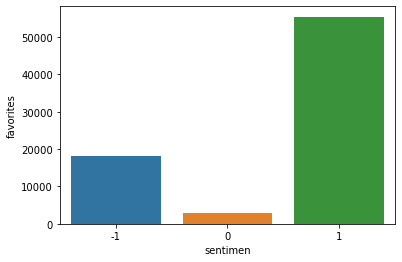

In [218]:
sns.barplot(x='sentimen',y='favorites',data=group_sent)

<AxesSubplot:xlabel='sentimen', ylabel='RT'>

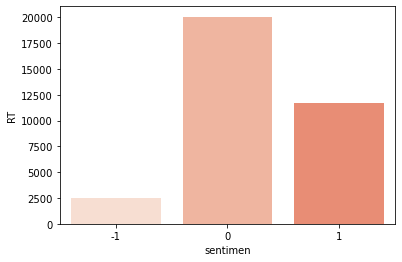

In [329]:
sns.barplot(x='sentimen',y='RT',data=group_sent)

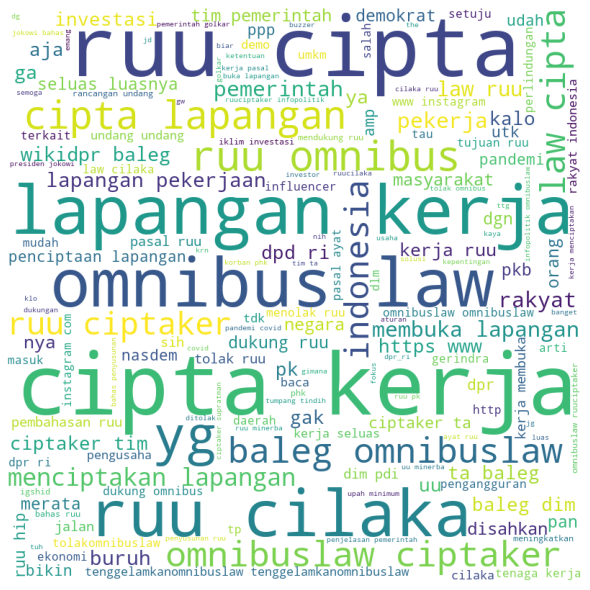

In [328]:
from wordcloud import WordCloud, STOPWORDS 
from nltk.corpus import stopwords

liststopwords =  set(stopwords.words('indonesian'))
tweets=''
for val in omnibus2['kalimat']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    tweets += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = liststopwords, 
                min_font_size = 10).generate(tweets)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

<AxesSubplot:xlabel='value', ylabel='key'>

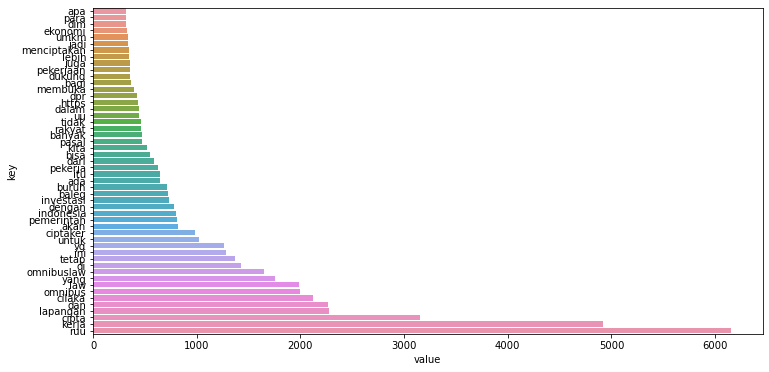

In [330]:
plt.figure(figsize=(12,6))
jumlah = bow_omnibus.sum(axis=0)
jumlah_dict={}
for i in jumlah.index:
    jumlah_dict[i] = jumlah[i]
sorted_jumlah_dict = sorted(jumlah_dict.items(), key=lambda item: item[1])
top_50 = sorted_jumlah_dict[-50:]
key = [i[0] for i in top_50]
value = [i[1] for i in top_50]
kamus = {'key':key,'value':value}
words = pd.DataFrame(data=kamus)
sns.barplot(y='key',x='value',data=words)

(array([18474.70833333, 18478.70833333, 18482.70833333, 18486.70833333,
        18490.70833333, 18494.70833333, 18498.70833333, 18502.70833333,
        18505.70833333, 18509.70833333]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

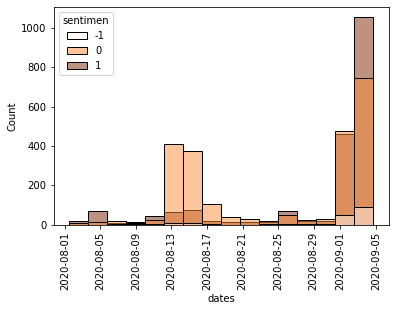

In [331]:
sns.set_palette("Reds")
terkini = omnibus2[(omnibus2['month']==8)|(omnibus2['month']==9)]
sns.histplot(terkini,x='dates',hue='sentimen',palette='Oranges')
plt.xticks(rotation=90)

(array([18373.70833333, 18382.70833333, 18403.70833333, 18413.70833333,
        18434.70833333, 18443.70833333, 18464.70833333, 18474.70833333,
        18495.70833333, 18505.70833333]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

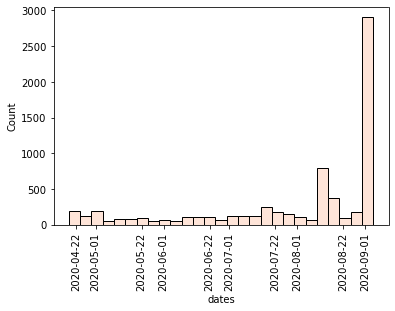

In [332]:
sns.histplot(omnibus2,x='dates')
plt.xticks(rotation=90)

<AxesSubplot:xlabel='hour', ylabel='count'>

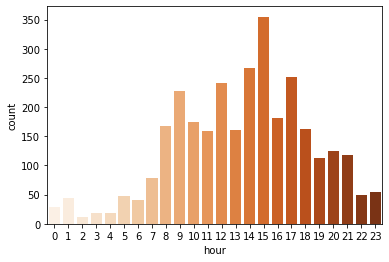

In [333]:
sns.countplot(x='hour',data=omnibus2[omnibus2['sentimen']==1],palette='Oranges')

<AxesSubplot:xlabel='hour', ylabel='count'>

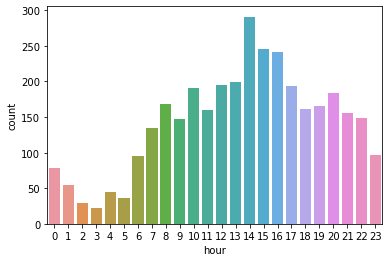

In [334]:
sns.countplot(x='hour',data=omnibus2[omnibus2['sentimen']==0])

<AxesSubplot:xlabel='hour', ylabel='count'>

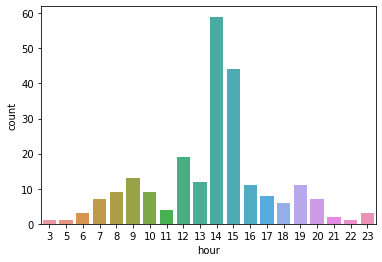

In [335]:
sns.countplot(x='hour',data=omnibus2[omnibus2['sentimen']==-1])

## 2.Random Forest

### A. TF_IDF

#### Tweet belum dibersihkan

In [336]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=200, random_state=0)
RF.fit(tf_train, train['sentimen'])

NameError: name 'tf_train' is not defined

In [47]:
predicted = RF.predict(tf_test)
unique_elements, counts_elements = np.unique(predicted, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[  -1    0    1]
 [ 347 1464  352]]


In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
matrix = classification_report(test['sentimen'],predicted)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

          -1       0.77      0.33      0.46       814
           0       0.61      0.84      0.71      1066
           1       0.40      0.50      0.44       283

    accuracy                           0.60      2163
   macro avg       0.59      0.56      0.54      2163
weighted avg       0.64      0.60      0.58      2163



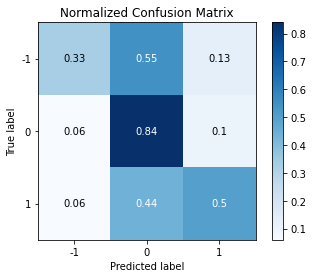

In [49]:
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(test['sentimen'], predicted, normalize=True)
plt.show()

#### Tweet sudah dibersihkan

In [337]:
RF = RandomForestClassifier(n_estimators=200, random_state=0)
RF.fit(clean_tf_train, train['sentimen'])

RandomForestClassifier(n_estimators=200, random_state=0)

In [338]:
predicted = RF.predict(clean_tf_test)
unique_elements, counts_elements = np.unique(predicted, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[  -1    0    1]
 [ 259 1516  388]]


In [339]:
matrix = classification_report(test['sentimen'],predicted)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

          -1       0.51      0.16      0.24       814
           0       0.54      0.77      0.63      1066
           1       0.21      0.29      0.24       283

    accuracy                           0.48      2163
   macro avg       0.42      0.40      0.37      2163
weighted avg       0.48      0.48      0.44      2163



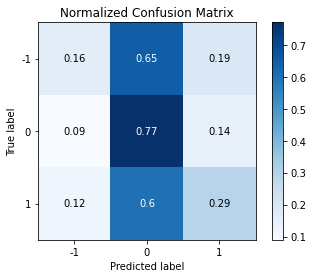

In [340]:
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(test['sentimen'], predicted, normalize=True)
plt.show()

### ROC

In [341]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

y_score = label_binarize(predicted,classes=[-1,0,1])
y_test = label_binarize(test['sentimen'],classes=[-1,0,1])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(-1,2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

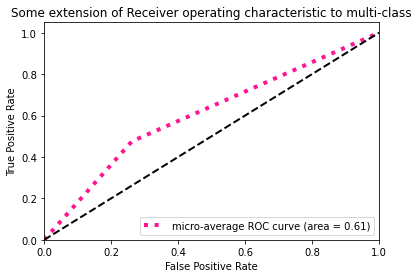

In [342]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

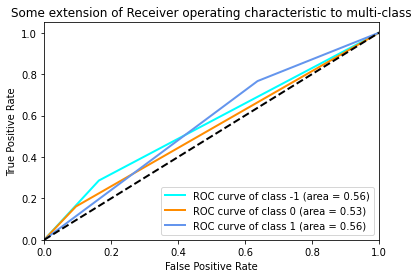

In [343]:
lw=2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(-1,2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [344]:
import seaborn as sns
y_prob = RF.predict_proba(clean_tf_test)
y_test=test['sentimen']

In [345]:
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",average="weighted")

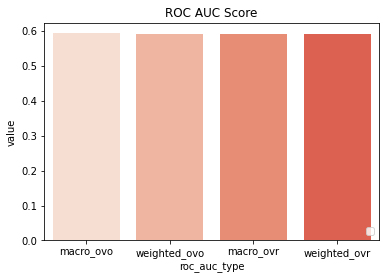

In [346]:
d= {'type':['macro_ovo','weighted_ovo','macro_ovr','weighted_ovr'],
    'value':[macro_roc_auc_ovo,weighted_roc_auc_ovr,macro_roc_auc_ovr,weighted_roc_auc_ovr]}
roc_auc_score = pd.DataFrame(data=d)

sns.barplot(x='type',y='value',data=roc_auc_score)

plt.xlabel('roc_auc_type')
plt.ylabel('value')
plt.title('ROC AUC Score')
plt.legend(loc="lower right")
plt.show()

#### EDA TFIDF RANDOM FOREST

In [347]:
#Predict sentiment dari dataset omnibuslaw
prediksi = RF.predict(tf_omnibus)
omnibus2['sentimen'] = prediksi
omnibus2.head()

,id,date,Tweet,RT,favorites,kalimat,sentimen,dates,hour,day_of_week,day,month
0,1301815267954061312,2020-09-04 09:32:01+00:00,Dengan omnibuslaw pemberi kerja dilarang membayar gaji dibawah gaji minimum.. #DukungOmnibusLaw,0,0,Dengan omnibuslaw pemberi kerja dilarang membayar gaji dibawah gaji minimum .. #DukungOmnibusLaw,1,2020-09-04 16:32:01+07:00,16,4,4,9
1,1301815086378491906,2020-09-04 09:31:17+00:00,"Pdhl idi sampe salesnl farmasinya udh teriak LD dr awal.. tergantung penilaianmu masih benarkah, belum omnibuslaw dll..masih elu belain ? Kebangetan lu",0,0,"Pdhl idi sampe salesnl farmasinya udh teriak LD dr awal .. tergantung penilaianmu masih benarkah , belum omnibuslaw dll .. masih elu belain ? Kebangetan lu",0,2020-09-04 16:31:17+07:00,16,4,4,9
2,1301814678675271681,2020-09-04 09:29:40+00:00,Dengan Omnibuslaw pekerja dan buruh yang lembur wajib dibayar.. #DukungOmnibusLaw,0,0,Dengan Omnibuslaw pekerja dan buruh yang lembur wajib dibayar .. #DukungOmnibusLaw,1,2020-09-04 16:29:40+07:00,16,4,4,9
3,1301814467383050242,2020-09-04 09:28:50+00:00,Omnibuslaw memberikan keringanan Izin UMKM.. #DukungOmnibusLaw,0,0,Omnibuslaw memberikan keringanan Izin UMKM .. #DukungOmnibusLaw,0,2020-09-04 16:28:50+07:00,16,4,4,9
4,1301814167431593984,2020-09-04 09:27:38+00:00,Dengan Omnibuslaw pengusaha wajib bayar lembur.. #DukungOmnibusLaw,0,0,Dengan Omnibuslaw pengusaha wajib bayar lembur .. #DukungOmnibusLaw,0,2020-09-04 16:27:38+07:00,16,4,4,9


<AxesSubplot:xlabel='sentimen', ylabel='count'>

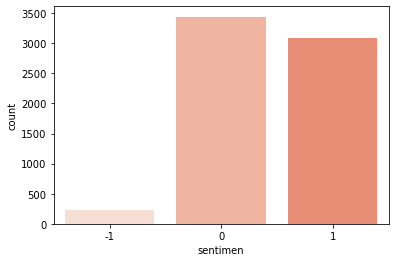

In [348]:
sns.countplot(x='sentimen',data=omnibus2)

In [349]:
group_sent = omnibus2.groupby(['sentimen']).sum()
group_sent['sentimen'] = group_sent.index
group_sent

,id,RT,favorites,hour,day_of_week,day,month,sentimen
sentimen,,,,,,,,
-1,2.968829e+20,2480.0,7845.0,3170.0,584.0,1788.0,1815.0,-1
0,4.434768e+21,20057.0,45044.0,46730.0,9701.0,38734.0,26266.0,0
1,3.991387e+21,11663.0,23674.0,41704.0,8132.0,30115.0,24017.0,1


<AxesSubplot:xlabel='sentimen', ylabel='favorites'>

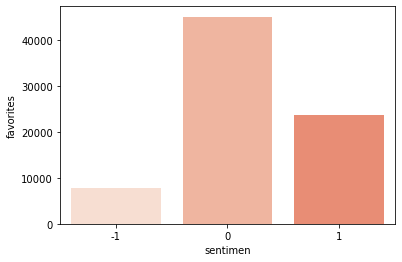

In [350]:
sns.barplot(x='sentimen',y='favorites',data=group_sent)

<AxesSubplot:xlabel='sentimen', ylabel='RT'>

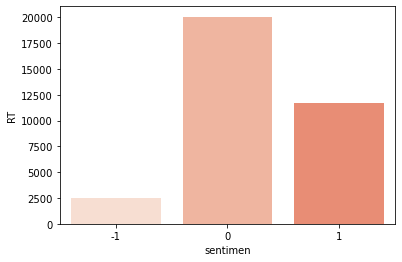

In [351]:
sns.barplot(x='sentimen',y='RT',data=group_sent)

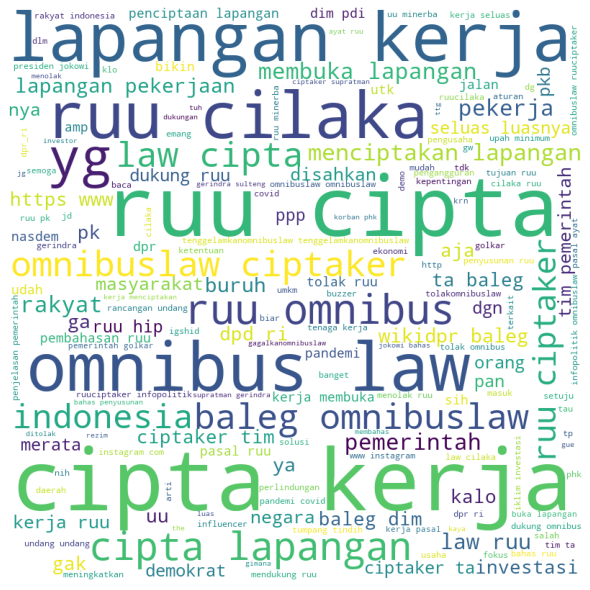

In [352]:
from wordcloud import WordCloud, STOPWORDS 
from nltk.corpus import stopwords

liststopwords =  set(stopwords.words('indonesian'))
tweets=''
for val in omnibus2['kalimat']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    tweets += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = liststopwords, 
                min_font_size = 10).generate(tweets)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

<AxesSubplot:xlabel='value', ylabel='key'>

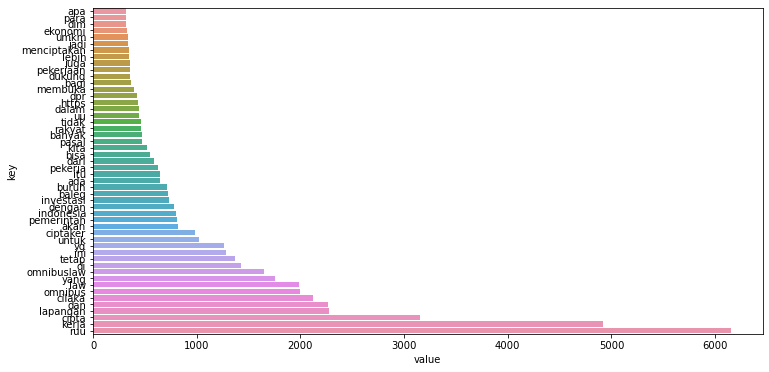

In [330]:
plt.figure(figsize=(12,6))
jumlah = bow_omnibus.sum(axis=0)
jumlah_dict={}
for i in jumlah.index:
    jumlah_dict[i] = jumlah[i]
sorted_jumlah_dict = sorted(jumlah_dict.items(), key=lambda item: item[1])
top_50 = sorted_jumlah_dict[-50:]
key = [i[0] for i in top_50]
value = [i[1] for i in top_50]
kamus = {'key':key,'value':value}
words = pd.DataFrame(data=kamus)
sns.barplot(y='key',x='value',data=words)

(array([18474.70833333, 18478.70833333, 18482.70833333, 18486.70833333,
        18490.70833333, 18494.70833333, 18498.70833333, 18502.70833333,
        18505.70833333, 18509.70833333]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

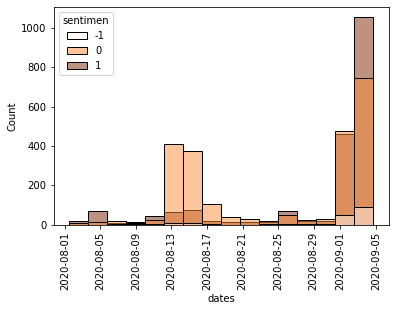

In [354]:
sns.set_palette("Reds")
terkini = omnibus2[(omnibus2['month']==8)|(omnibus2['month']==9)]
sns.histplot(terkini,x='dates',hue='sentimen',palette='Oranges')
plt.xticks(rotation=90)

(array([18373.70833333, 18382.70833333, 18403.70833333, 18413.70833333,
        18434.70833333, 18443.70833333, 18464.70833333, 18474.70833333,
        18495.70833333, 18505.70833333]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

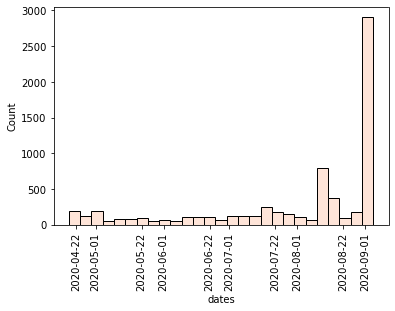

In [355]:
sns.histplot(omnibus2,x='dates')
plt.xticks(rotation=90)

<AxesSubplot:xlabel='hour', ylabel='count'>

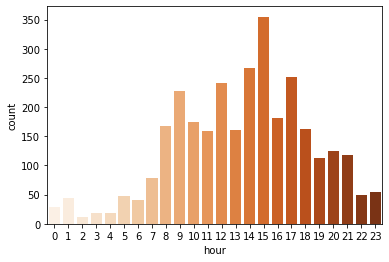

In [356]:
sns.countplot(x='hour',data=omnibus2[omnibus2['sentimen']==1],palette='Oranges')

<AxesSubplot:xlabel='hour', ylabel='count'>

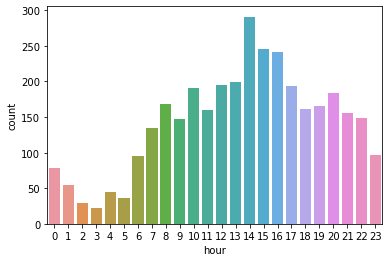

In [357]:
sns.countplot(x='hour',data=omnibus2[omnibus2['sentimen']==0])

<AxesSubplot:xlabel='hour', ylabel='count'>

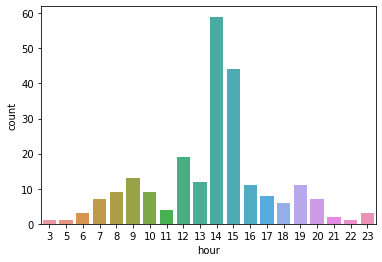

In [358]:
sns.countplot(x='hour',data=omnibus2[omnibus2['sentimen']==-1])

### B. Bag of words

#### Count Vectorizer

#### Tweet sudah dibersihkan

In [359]:
RF = RandomForestClassifier(n_estimators=200, random_state=0)
RF.fit(bow_train_cv_clean,train_cv_clean['sentimen'])

RandomForestClassifier(n_estimators=200, random_state=0)

In [360]:
predicted = RF.predict(bow_test_cv_clean)
unique_elements, counts_elements = np.unique(predicted, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[  -1    0    1]
 [ 179 1590  394]]


In [361]:
matrix = classification_report(test_cv_clean['sentimen'],predicted)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

          -1       0.69      0.15      0.25       814
           0       0.56      0.84      0.67      1066
           1       0.30      0.42      0.35       283

    accuracy                           0.53      2163
   macro avg       0.52      0.47      0.42      2163
weighted avg       0.58      0.53      0.47      2163



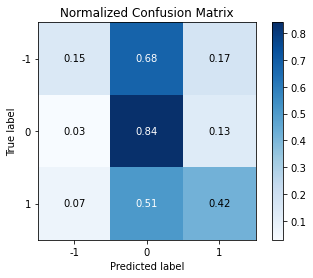

In [362]:
skplt.metrics.plot_confusion_matrix(test['sentimen'], predicted, normalize=True)
plt.show()

### ROC

In [363]:
y_score = label_binarize(predicted,classes=[-1,0,1])
y_test = label_binarize(test['sentimen'],classes=[-1,0,1])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(-1,2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

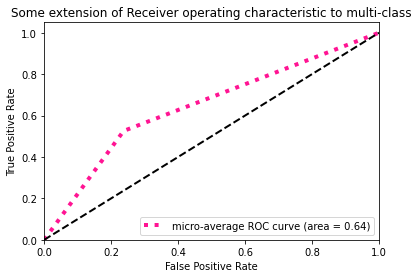

In [364]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

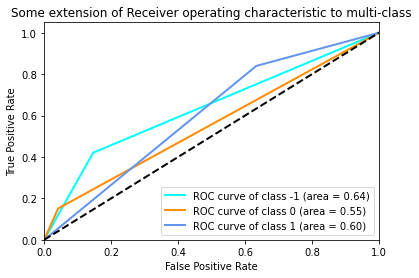

In [365]:
lw=2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(-1,2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [366]:
y_prob = RF.predict_proba(bow_test_cv_clean)
y_test=test['sentimen']

In [367]:
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",average="weighted")

TypeError: 'DataFrame' object is not callable

In [ ]:
d= {'type':['macro_ovo','weighted_ovo','macro_ovr','weighted_ovr'],
    'value':[macro_roc_auc_ovo,weighted_roc_auc_ovr,macro_roc_auc_ovr,weighted_roc_auc_ovr]}
roc_auc_score = pd.DataFrame(data=d)

sns.barplot(x='type',y='value',data=roc_auc_score)

plt.xlabel('roc_auc_type')
plt.ylabel('value')
plt.title('ROC AUC Score')
plt.legend(loc="lower right")
plt.show()

#### EDA BOW Random Forest

In [371]:
#Predict sentiment dari dataset omnibuslaw
prediksi = RF.predict(bow_omnibus)
omnibus2['sentimen'] = prediksi
omnibus2.head()

,id,date,Tweet,RT,favorites,kalimat,sentimen,dates,hour,day_of_week,day,month
0,1301815267954061312,2020-09-04 09:32:01+00:00,Dengan omnibuslaw pemberi kerja dilarang membayar gaji dibawah gaji minimum.. #DukungOmnibusLaw,0,0,Dengan omnibuslaw pemberi kerja dilarang membayar gaji dibawah gaji minimum .. #DukungOmnibusLaw,0,2020-09-04 16:32:01+07:00,16,4,4,9
1,1301815086378491906,2020-09-04 09:31:17+00:00,"Pdhl idi sampe salesnl farmasinya udh teriak LD dr awal.. tergantung penilaianmu masih benarkah, belum omnibuslaw dll..masih elu belain ? Kebangetan lu",0,0,"Pdhl idi sampe salesnl farmasinya udh teriak LD dr awal .. tergantung penilaianmu masih benarkah , belum omnibuslaw dll .. masih elu belain ? Kebangetan lu",-1,2020-09-04 16:31:17+07:00,16,4,4,9
2,1301814678675271681,2020-09-04 09:29:40+00:00,Dengan Omnibuslaw pekerja dan buruh yang lembur wajib dibayar.. #DukungOmnibusLaw,0,0,Dengan Omnibuslaw pekerja dan buruh yang lembur wajib dibayar .. #DukungOmnibusLaw,0,2020-09-04 16:29:40+07:00,16,4,4,9
3,1301814467383050242,2020-09-04 09:28:50+00:00,Omnibuslaw memberikan keringanan Izin UMKM.. #DukungOmnibusLaw,0,0,Omnibuslaw memberikan keringanan Izin UMKM .. #DukungOmnibusLaw,0,2020-09-04 16:28:50+07:00,16,4,4,9
4,1301814167431593984,2020-09-04 09:27:38+00:00,Dengan Omnibuslaw pengusaha wajib bayar lembur.. #DukungOmnibusLaw,0,0,Dengan Omnibuslaw pengusaha wajib bayar lembur .. #DukungOmnibusLaw,0,2020-09-04 16:27:38+07:00,16,4,4,9


<AxesSubplot:xlabel='sentimen', ylabel='count'>

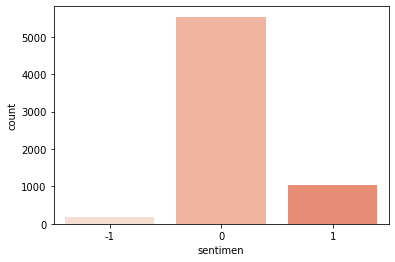

In [372]:
sns.countplot(x='sentimen',data=omnibus2)

In [373]:
group_sent = omnibus2.groupby(['sentimen']).sum()
group_sent['sentimen'] = group_sent.index
group_sent

,id,RT,favorites,hour,day_of_week,day,month,sentimen
sentimen,,,,,,,,
-1,2.332763e+20,2847.0,9017.0,2469.0,488.0,1826.0,1383.0,-1
0,7.134620e+21,26095.0,56148.0,74634.0,15218.0,58650.0,42509.0,0
1,1.355142e+21,5258.0,11398.0,14501.0,2711.0,10161.0,8206.0,1


<AxesSubplot:xlabel='sentimen', ylabel='favorites'>

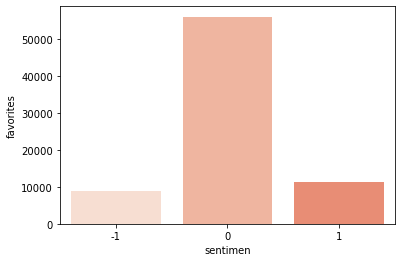

In [374]:
sns.barplot(x='sentimen',y='favorites',data=group_sent)

<AxesSubplot:xlabel='sentimen', ylabel='RT'>

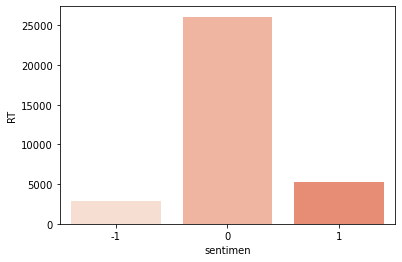

In [375]:
sns.barplot(x='sentimen',y='RT',data=group_sent)

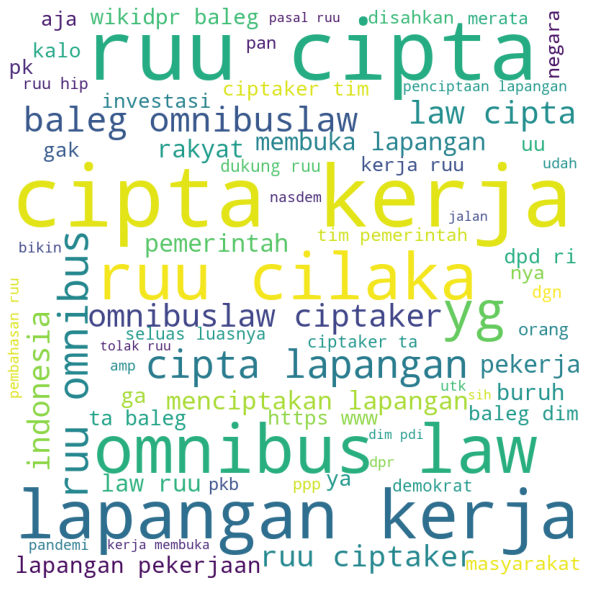

In [376]:
from wordcloud import WordCloud, STOPWORDS 
from nltk.corpus import stopwords

liststopwords =  set(stopwords.words('indonesian'))
tweets=''
for val in omnibus2['kalimat']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    tweets += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = liststopwords, 
                min_font_size = 10).generate(tweets)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

<AxesSubplot:xlabel='value', ylabel='key'>

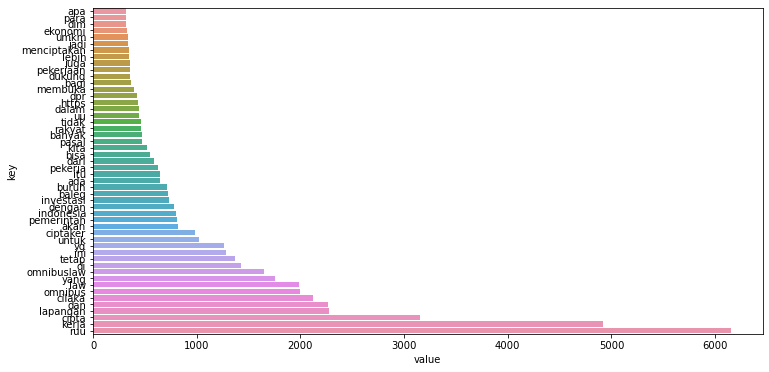

In [377]:
plt.figure(figsize=(12,6))
jumlah = bow_omnibus.sum(axis=0)
jumlah_dict={}
for i in jumlah.index:
    jumlah_dict[i] = jumlah[i]
sorted_jumlah_dict = sorted(jumlah_dict.items(), key=lambda item: item[1])
top_50 = sorted_jumlah_dict[-50:]
key = [i[0] for i in top_50]
value = [i[1] for i in top_50]
kamus = {'key':key,'value':value}
words = pd.DataFrame(data=kamus)
sns.barplot(y='key',x='value',data=words)

(array([18474.70833333, 18478.70833333, 18482.70833333, 18486.70833333,
        18490.70833333, 18494.70833333, 18498.70833333, 18502.70833333,
        18505.70833333, 18509.70833333]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

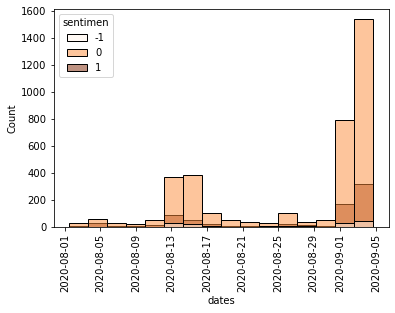

In [378]:
sns.set_palette("Reds")
terkini = omnibus2[(omnibus2['month']==8)|(omnibus2['month']==9)]
sns.histplot(terkini,x='dates',hue='sentimen',palette='Oranges')
plt.xticks(rotation=90)

(array([18373.70833333, 18382.70833333, 18403.70833333, 18413.70833333,
        18434.70833333, 18443.70833333, 18464.70833333, 18474.70833333,
        18495.70833333, 18505.70833333]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

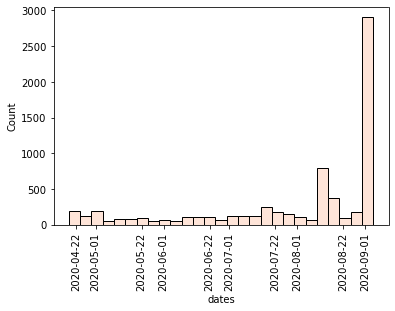

In [379]:
sns.histplot(omnibus2,x='dates')
plt.xticks(rotation=90)

<AxesSubplot:xlabel='hour', ylabel='count'>

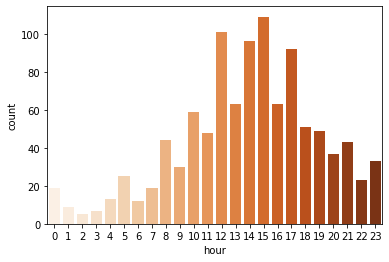

In [380]:
sns.countplot(x='hour',data=omnibus2[omnibus2['sentimen']==1],palette='Oranges')

<AxesSubplot:xlabel='hour', ylabel='count'>

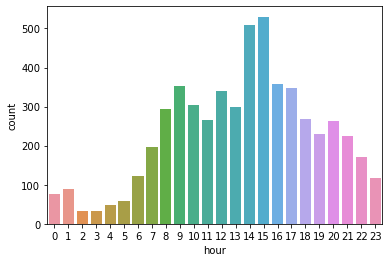

In [381]:
sns.countplot(x='hour',data=omnibus2[omnibus2['sentimen']==0])

<AxesSubplot:xlabel='hour', ylabel='count'>

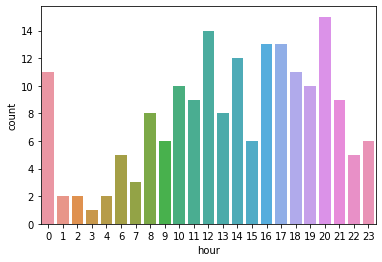

In [382]:
sns.countplot(x='hour',data=omnibus2[omnibus2['sentimen']==-1])

## 3.Logistic Regression

### A. TF_IDF

#### Tweet belum dibersihkan

In [383]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(tf_train, train['sentimen'])

NameError: name 'tf_train' is not defined

In [ ]:
predicted = LR.predict(tf_test)
unique_elements, counts_elements = np.unique(predicted, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
matrix = classification_report(test['sentimen'],predicted)
print('Classification report : \n',matrix)

In [ ]:
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(test['sentimen'], predicted, normalize=True)
plt.show()

#### Tweet sudah dibersihkan

In [384]:
LR = LogisticRegression()
LR.fit(clean_tf_train, train['sentimen'])

LogisticRegression()

In [385]:
predicted = LR.predict(clean_tf_test)
unique_elements, counts_elements = np.unique(predicted, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[  -1    0    1]
 [ 117 1881  165]]


In [386]:
matrix = classification_report(test['sentimen'],predicted)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

          -1       0.60      0.09      0.15       814
           0       0.52      0.93      0.67      1066
           1       0.29      0.17      0.21       283

    accuracy                           0.51      2163
   macro avg       0.47      0.39      0.34      2163
weighted avg       0.52      0.51      0.41      2163



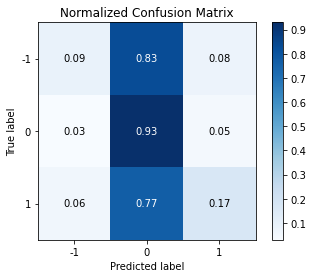

In [387]:

skplt.metrics.plot_confusion_matrix(test['sentimen'], predicted, normalize=True)
plt.show()

### ROC AUC

In [388]:
y_score = label_binarize(predicted,classes=[-1,0,1])
y_test = label_binarize(test['sentimen'],classes=[-1,0,1])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(-1,2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

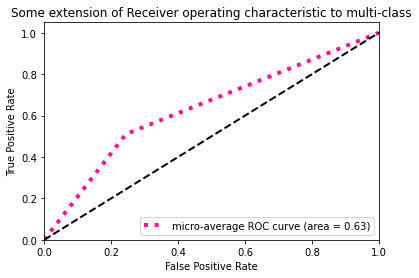

In [389]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

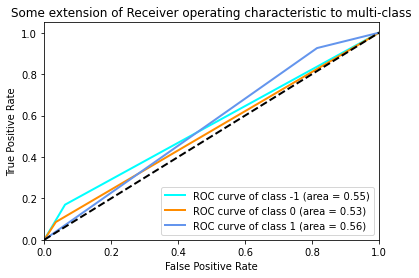

In [390]:
lw=2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(-1,2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [391]:

y_prob = LR.predict_proba(clean_tf_test)
y_test=test['sentimen']

In [392]:
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",average="weighted")

TypeError: 'DataFrame' object is not callable

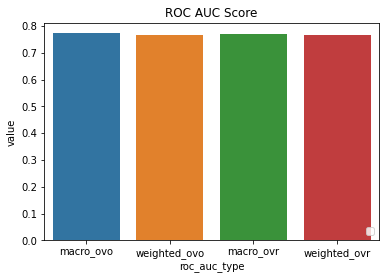

In [93]:
d= {'type':['macro_ovo','weighted_ovo','macro_ovr','weighted_ovr'],
    'value':[macro_roc_auc_ovo,weighted_roc_auc_ovr,macro_roc_auc_ovr,weighted_roc_auc_ovr]}
roc_auc_score = pd.DataFrame(data=d)

sns.barplot(x='type',y='value',data=roc_auc_score)

plt.xlabel('roc_auc_type')
plt.ylabel('value')
plt.title('ROC AUC Score')
plt.legend(loc="lower right")
plt.show()

### Bag of Words

#### Count Vectorizer

#### Tweet sudah dibersihkan

In [393]:
LR = LogisticRegression()
LR.fit(bow_train_cv_clean,train['sentimen'])

c:\users\win 10\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [394]:
predicted = LR.predict(bow_test_cv_clean)
unique_elements, counts_elements = np.unique(predicted, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[  -1    0    1]
 [ 335 1333  495]]


In [395]:
matrix = classification_report(test_cv_clean['sentimen'],predicted)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

          -1       0.63      0.26      0.37       814
           0       0.59      0.74      0.66      1066
           1       0.28      0.49      0.35       283

    accuracy                           0.53      2163
   macro avg       0.50      0.50      0.46      2163
weighted avg       0.57      0.53      0.51      2163



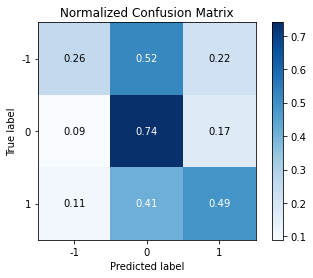

In [396]:
skplt.metrics.plot_confusion_matrix(test_cv_clean['sentimen'], predicted, normalize=True)
plt.show()

#### ROC AUC LOGRES

In [397]:
y_score = label_binarize(predicted,classes=[-1,0,1])
y_test = label_binarize(test['sentimen'],classes=[-1,0,1])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(-1,2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

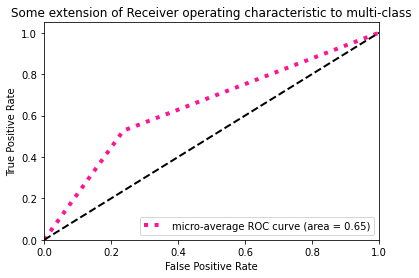

In [398]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

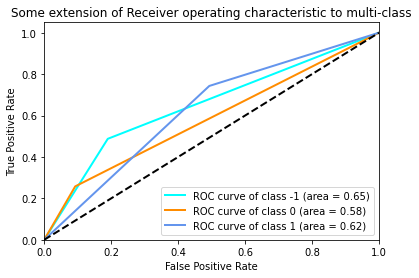

In [399]:
lw=2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(-1,2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [104]:
y_prob = LR.predict_proba(bow_test_cv_clean)
y_test=test['sentimen']

In [105]:
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",average="weighted")

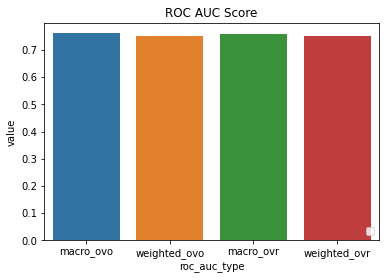

In [106]:
d= {'type':['macro_ovo','weighted_ovo','macro_ovr','weighted_ovr'],
    'value':[macro_roc_auc_ovo,weighted_roc_auc_ovr,macro_roc_auc_ovr,weighted_roc_auc_ovr]}
roc_auc_score = pd.DataFrame(data=d)

sns.barplot(x='type',y='value',data=roc_auc_score)

plt.xlabel('roc_auc_type')
plt.ylabel('value')
plt.title('ROC AUC Score')
plt.legend(loc="lower right")
plt.show()

## 4. SGD

### A.TFIDF

#### Tweet sudah dibersihkan

In [400]:
SGD = SGDClassifier(loss='log')
SGD.fit(clean_tf_train, train['sentimen'])

SGDClassifier(loss='log')

In [401]:
predicted = SGD.predict(clean_tf_test)
unique_elements, counts_elements = np.unique(predicted, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[  -1    0    1]
 [  86 1968  109]]


In [402]:
matrix = classification_report(test['sentimen'],predicted)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

          -1       0.67      0.07      0.13       814
           0       0.52      0.96      0.67      1066
           1       0.21      0.08      0.12       283

    accuracy                           0.51      2163
   macro avg       0.47      0.37      0.31      2163
weighted avg       0.54      0.51      0.40      2163



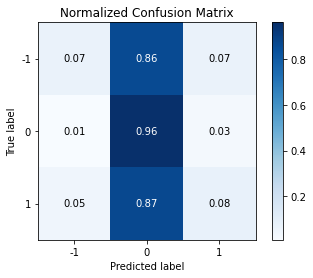

In [403]:
skplt.metrics.plot_confusion_matrix(test['sentimen'], predicted, normalize=True)
plt.show()

### ROC 

In [404]:
y_score = label_binarize(predicted,classes=[-1,0,1])
y_test = label_binarize(test['sentimen'],classes=[-1,0,1])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(-1,2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

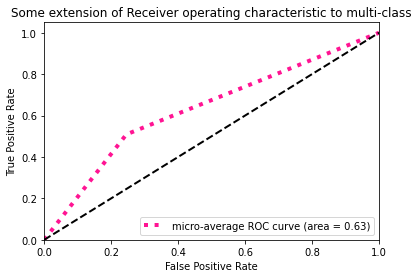

In [405]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

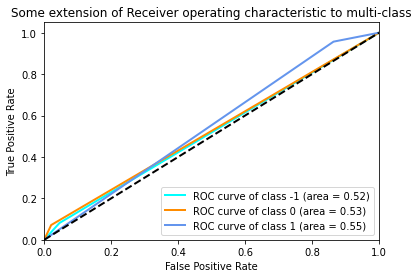

In [406]:
lw=2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(-1,2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [407]:
y_prob = SGD.predict_proba(clean_tf_test)
y_test=test['sentimen']

In [408]:
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",average="weighted")

TypeError: 'DataFrame' object is not callable

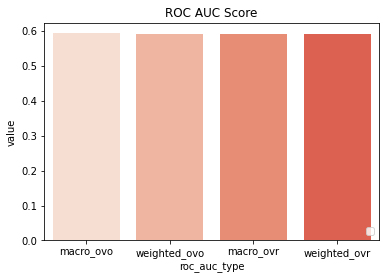

In [409]:
d= {'type':['macro_ovo','weighted_ovo','macro_ovr','weighted_ovr'],
    'value':[macro_roc_auc_ovo,weighted_roc_auc_ovr,macro_roc_auc_ovr,weighted_roc_auc_ovr]}
roc_auc_score = pd.DataFrame(data=d)

sns.barplot(x='type',y='value',data=roc_auc_score)

plt.xlabel('roc_auc_type')
plt.ylabel('value')
plt.title('ROC AUC Score')
plt.legend(loc="lower right")
plt.show()

#### Tweet belum dibersihkan

In [ ]:
from sklearn.linear_model import SGDClassifier
SGD = SGDClassifier()
SGD.fit(tf_train, train['sentimen'])

In [ ]:
predicted = SGD.predict(tf_test)
unique_elements, counts_elements = np.unique(predicted, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
matrix = classification_report(test['sentimen'],predicted)
print('Classification report : \n',matrix)

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(test['sentimen'], predicted, normalize=True)
plt.show()

### Bag of Words

#### Tweet sudah dibersihkan

In [410]:
SGD = SGDClassifier(loss='log')
SGD.fit(bow_train_cv_clean,train['sentimen'])

SGDClassifier(loss='log')

In [411]:
predicted = SGD.predict(bow_test_cv_clean)
unique_elements, counts_elements = np.unique(predicted, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[  -1    0    1]
 [ 372 1334  457]]


In [412]:
matrix = classification_report(test_cv_clean['sentimen'],predicted)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

          -1       0.63      0.29      0.39       814
           0       0.60      0.74      0.66      1066
           1       0.29      0.47      0.36       283

    accuracy                           0.54      2163
   macro avg       0.51      0.50      0.47      2163
weighted avg       0.57      0.54      0.52      2163



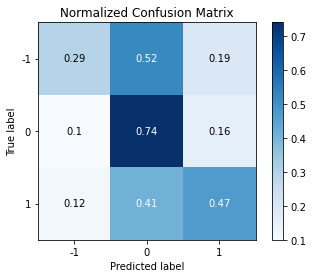

In [413]:
skplt.metrics.plot_confusion_matrix(test['sentimen'], predicted, normalize=True)
plt.show()

### ROC

In [414]:
y_score = label_binarize(predicted,classes=[-1,0,1])
y_test = label_binarize(test['sentimen'],classes=[-1,0,1])
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(-1,2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

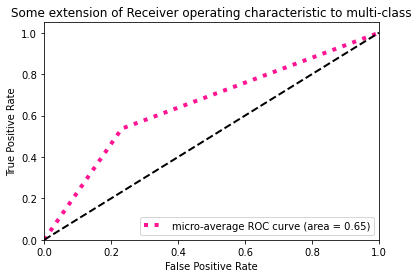

In [415]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

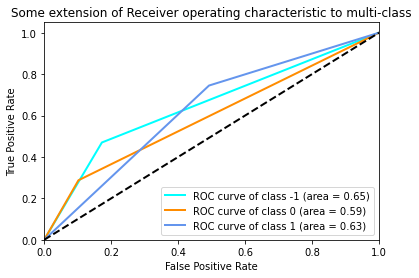

In [416]:
lw=2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(-1,2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [417]:
#gatau gabisa, probability estimates are not available for loss='hinge'
y_prob = SGD.predict_proba(bow_test_cv_clean)
y_test=test['sentimen']

In [418]:
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",average="weighted")

TypeError: 'DataFrame' object is not callable

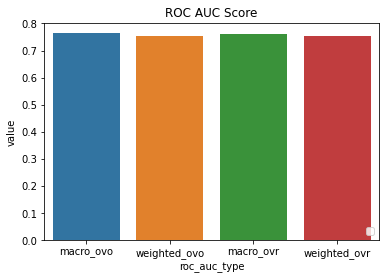

In [157]:
d= {'type':['macro_ovo','weighted_ovo','macro_ovr','weighted_ovr'],
    'value':[macro_roc_auc_ovo,weighted_roc_auc_ovr,macro_roc_auc_ovr,weighted_roc_auc_ovr]}
roc_auc_score = pd.DataFrame(data=d)

sns.barplot(x='type',y='value',data=roc_auc_score)

plt.xlabel('roc_auc_type')
plt.ylabel('value')
plt.title('ROC AUC Score')
plt.legend(loc="lower right")
plt.show()

## 5. SVM

### TFIDF

In [ ]:
import time
from sklearn import svm
from sklearn.metrics import classification_report
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear', C=1, gamma=0.001)
t0 = time.time()
classifier_linear.fit(clean_tf_train, train['sentimen'])
t1 = time.time()
prediction_linear = classifier_linear.predict(clean_tf_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(test['sentiment'], prediction_linear, output_dict=True)
print('positive: ', report['1'])
print('negative: ', report['-1'])
print('neutral: ', report['0'])

In [ ]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

svc_param_selection(train_vectors, df_train['sentiment'], 5)


## Deep Learning

In [ ]:
# X dan y belum displit 

tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

In [ ]:
X_seq = tk.texts_to_sequences(X)


print('"{}" is converted into {}'.format(X[0], X_seq[0]))


def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_oh = one_hot_seq(X_seq)
print('"{}" is converted into {}'.format(X_seq[0], X_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_oh[0].sum()))

In [ ]:
le = LabelEncoder()
y_le = le.fit_transform(y)
#y_test_le = le.transform(y_test)
y_oh = to_categorical(y_le)
#y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y[0], y_le[0]))
print('"{}" is converted into {}'.format(y_le[0], y_oh[0]))


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_oh, y_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train.shape[0] == y_train.shape[0]

print('Shape of validation set:',X_valid.shape)

In [ ]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

In [ ]:
def deep_model(model, X, y):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X
                       , y
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history





base_history = deep_model(base_model, X_train, y_train)

In [ ]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()




eval_metric(base_history, 'loss')


eval_metric(base_history, 'accuracy')

In [ ]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

In [ ]:
reduced_history = deep_model(reduced_model, X_train, y_train)

In [ ]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

compare_loss_with_baseline(reduced_history, 'Reduced Model')

In [ ]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()


In [ ]:
reg_history = deep_model(reg_model, X_train, y_train)

In [ ]:
compare_loss_with_baseline(reg_history, 'Regularized Model')

In [ ]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()





drop_history = deep_model(drop_model, X_train, y_train)



compare_loss_with_baseline(drop_history, 'Dropout Model')

In [ ]:
def test_model(model, epoch_stop):
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_valid, y_valid)
    
    return results




base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

In [ ]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

In [ ]:
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

In [ ]:
drop_results = test_model(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))


In [ ]:
coba = df_test.tweets.copy()
tk.fit_on_texts(coba)

coba_seq = tk.texts_to_sequences(coba)
print('"{}" is converted into {}'.format(coba[0], coba_seq[0]))

coba_oh = one_hot_seq(coba_seq)

print('"{}" is converted into {}'.format(coba_seq, coba_oh))
print('For this example we have {} features with a value of 1.'.format(coba_oh[0].sum()))

predicted = drop_model.predict(coba_oh)
predicted.shape

In [ ]:
list_predict = predicted.tolist()
df_predict = pd.DataFrame(list_predict, columns=['0', '1', '2'])
df_predict.head()

In [ ]:
df_predict_rounded = df_predict.round()
df_predict_rounded.head()

In [ ]:
predict_sentiment = []

for i in range(len(df_predict_rounded)):
    if (df_predict_rounded.iloc[i, 0] == 1) and (df_predict_rounded.iloc[i, 1] == 0) and (df_predict_rounded.iloc[i, 2] == 0):
        predict_sentiment.append(0)
    elif (df_predict_rounded.iloc[i, 0] == 0) and (df_predict_rounded.iloc[i, 1] == 1) and (df_predict_rounded.iloc[i, 2] == 0):
        predict_sentiment.append(1)
    elif (df_predict_rounded.iloc[i, 0] == 0) and (df_predict_rounded.iloc[i, 1] == 0) and (df_predict_rounded.iloc[i, 2] == 1):
        predict_sentiment.append(2)
    else:
        predict_sentiment.append(np.nan)
predict_sentiment




df_result = pd.DataFrame(predict_sentiment, columns=['sentiment'])
df_result.head()